In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter
import re
import nltk

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
dataset = load_dataset("udmurtNLP/udmurt-russian-parallel-corpora")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/101833 [00:00<?, ? examples/s]

In [5]:
df = pd.DataFrame(dataset['train'])

In [6]:
!pip3 install uniparser-udmurt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.9 MB/s eta 0:00:00


In [7]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.3 MB/s eta 0:00:00


In [8]:
from uniparser_udmurt import UdmurtAnalyzer
import pymorphy3

In [9]:
udm_analyzer = UdmurtAnalyzer(mode = 'strict')
ru_analyzer = pymorphy3.MorphAnalyzer()

In [ ]:
def extract_udm_pos(text):
    """Извлечение POS-разметки для удмуртского текста"""
    words = text.split()
    pos_tags = []

    # Анализ всего предложения как списка слов
    all_analyses = udm_analyzer.analyze_words(words)

    # Обработка каждого слова
    for word_analyses in all_analyses:
        if word_analyses:  # Если есть анализ
            # Берем первый анализ (самый вероятный)
            best_analysis = word_analyses[0]

            # Извлекаем грамматическую информацию
            if hasattr(best_analysis, 'gramm') and best_analysis.gramm:
                # POS-тег - первая граммема через запятой
                pos_tag = best_analysis.gramm.split(',')[0]
            else:
                # Попытка извлечь из глосса
                if hasattr(best_analysis, 'gloss') and 'v' in best_analysis.gloss.lower():
                    pos_tag = 'V'
                elif hasattr(best_analysis, 'gloss') and 'n' in best_analysis.gloss.lower():
                    pos_tag = 'N'
                else:
                    pos_tag = 'UNK'
        else:
            pos_tag = 'UNK'

        pos_tags.append(pos_tag)

    return ' '.join(pos_tags)

In [ ]:
def extract_ru_pos(text):
    """Извлечение POS-разметки для русского текста"""
    words = text.split()
    pos_tags = []

    for word in words:
        # Удаление пунктуации
        clean_word = word.strip('.,!?;:"\'()[]')

        # Анализ слова
        parsed = ru_analyzer.parse(clean_word)[0]
        pos_tag = parsed.tag.POS if parsed.tag.POS else 'UNK'
        pos_tags.append(pos_tag)

    return ' '.join(pos_tags)

In [ ]:
sample_df = df.sample(1000).copy()

In [ ]:
sample_df['udm_pos'] = sample_df['udm'].apply(extract_udm_pos)
sample_df['ru_pos'] = sample_df['ru'].apply(extract_ru_pos)

In [ ]:
sample_df.to_csv('udmurt_russian_with_pos.csv', index=False)

Распределение POS-тегов в удмуртском языке:


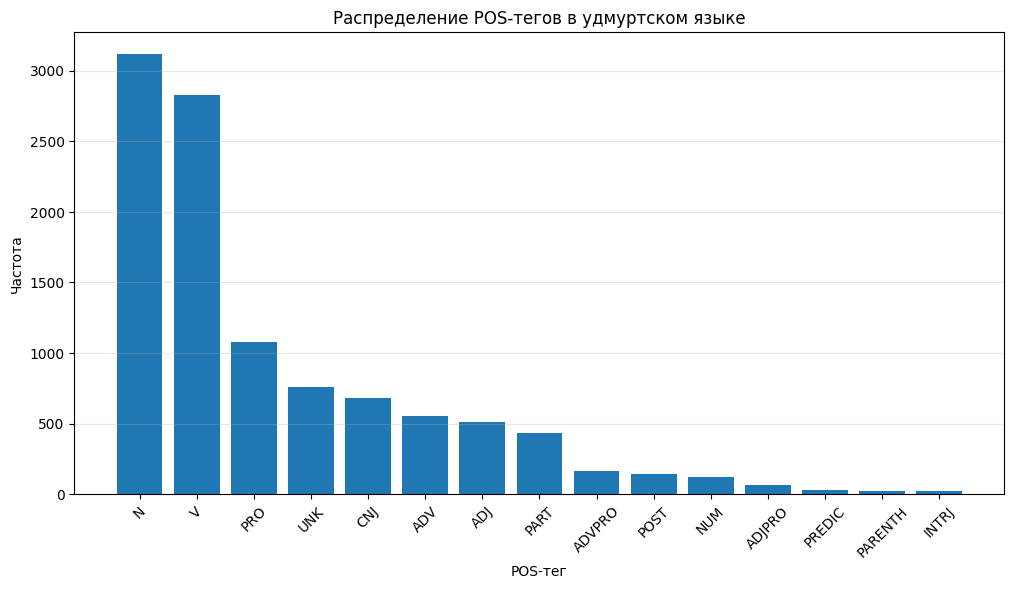


Распределение POS-тегов в русском языке:


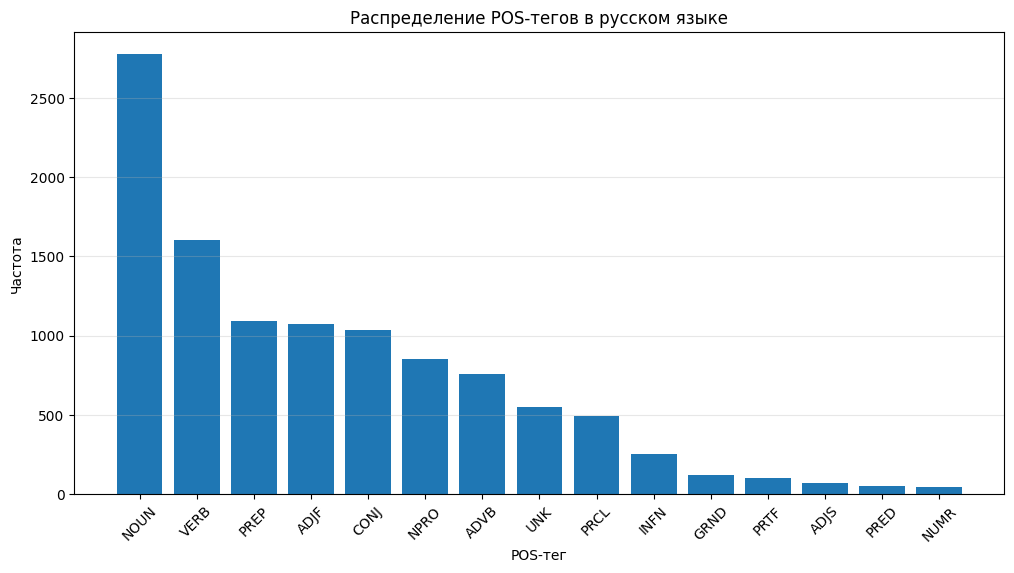

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_pos_distribution(pos_series, lang_name):
    """Визуализация распределения POS-тегов"""
    # Собираем все теги в один список
    all_tags = []
    for tags in pos_series:
        all_tags.extend(tags.split())

    # Считаем частоту тегов
    tag_counts = Counter(all_tags)
    common_tags = tag_counts.most_common(15)

    # Создаем график
    plt.figure(figsize=(12, 6))
    plt.bar([tag[0] for tag in common_tags], [tag[1] for tag in common_tags])
    plt.title(f'Распределение POS-тегов в {lang_name} языке')
    plt.xlabel('POS-тег')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    return tag_counts

# Визуализация для удмуртского языка
print("Распределение POS-тегов в удмуртском языке:")
udm_tag_counts = visualize_pos_distribution(sample_df['udm_pos'], 'удмуртском')

# Визуализация для русского языка
print("\nРаспределение POS-тегов в русском языке:")
ru_tag_counts = visualize_pos_distribution(sample_df['ru_pos'], 'русском')

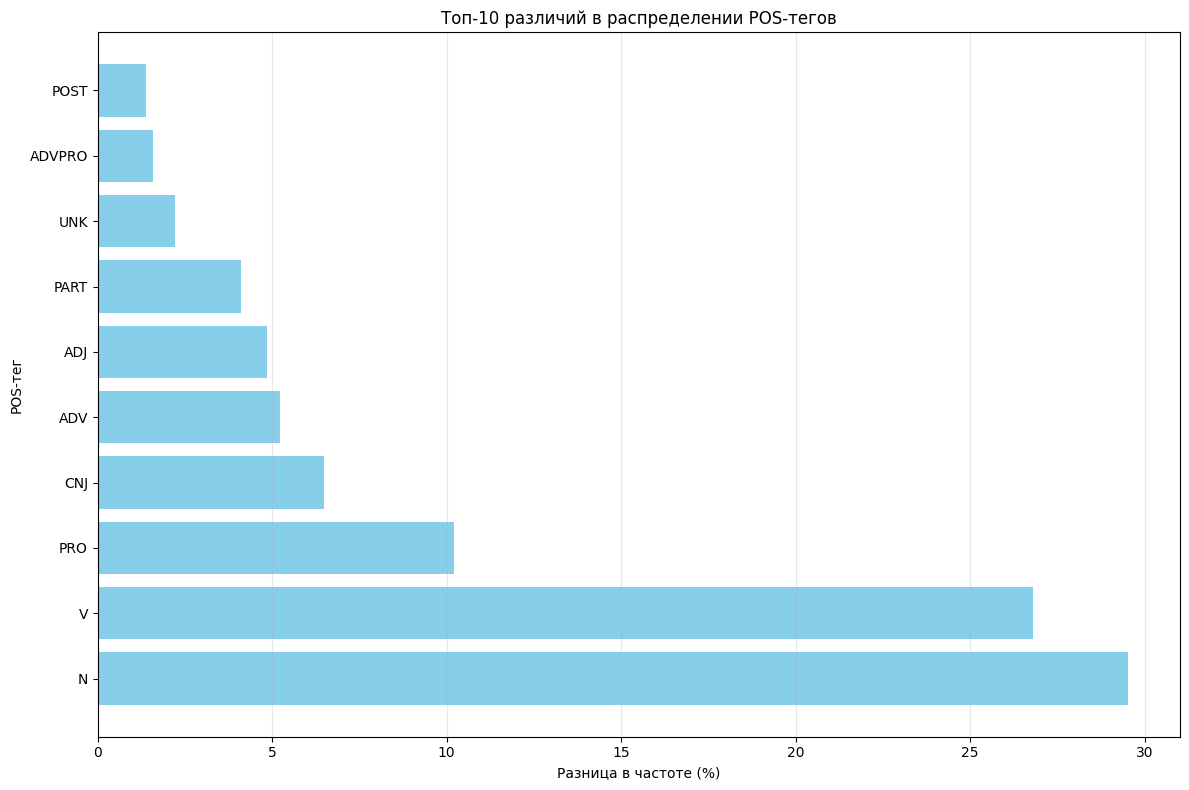

Сравнение распределения POS-тегов:
       Tag   Udm_Freq  Ru_Freq  Difference
0        N  29.536625  0.00000   29.536625
18       V  26.788591  0.00000   26.788591
24     PRO  10.215105  0.00000   10.215105
25     CNJ   6.481569  0.00000    6.481569
22     ADV   5.221264  0.00000    5.221264
8      ADJ   4.842225  0.00000    4.842225
32    PART   4.112575  0.00000    4.112575
4      UNK   7.182792  4.97948    2.203311
14  ADVPRO   1.582488  0.00000    1.582488
20    POST   1.383493  0.00000    1.383493


In [ ]:
# Сравнение распределений POS-тегов
def compare_pos_distributions(udm_counts, ru_counts):
    """Сравнение распределения POS-тегов между языками"""
    # Создаем общий список тегов
    all_tags = set(udm_counts.keys()) | set(ru_counts.keys())

    # Нормализуем частоты
    udm_total = sum(udm_counts.values())
    ru_total = sum(ru_counts.values())

    # Создаем DataFrame для сравнения
    compare_data = []
    for tag in all_tags:
        udm_freq = udm_counts.get(tag, 0) / udm_total * 100
        ru_freq = ru_counts.get(tag, 0) / ru_total * 100
        diff = udm_freq - ru_freq
        compare_data.append([tag, udm_freq, ru_freq, diff])

    # Сортируем по разнице
    compare_df = pd.DataFrame(compare_data, columns=['Tag', 'Udm_Freq', 'Ru_Freq', 'Difference'])
    compare_df = compare_df.sort_values('Difference', ascending=False)

    # Визуализация топ-10 различий
    plt.figure(figsize=(12, 8))
    plt.barh(compare_df['Tag'].head(10), compare_df['Difference'].head(10), color='skyblue')
    plt.title('Топ-10 различий в распределении POS-тегов')
    plt.xlabel('Разница в частоте (%)')
    plt.ylabel('POS-тег')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return compare_df

# Сравнение распределений
pos_comparison = compare_pos_distributions(udm_tag_counts, ru_tag_counts)
print("Сравнение распределения POS-тегов:")
print(pos_comparison.head(10))